# Scenario C: The Two-Putt Challenge

Goal: Two distinct shots to get from $(0,0)$ to $(4.5, 3.4)$.
Shot 1: Go through midpoint $(2.6, 1)$ and come to a "stop" (speed $10^{-3}$ m/s).
Shot 2: From that stopping point, go through midpoint $(4, 3.8)$ and end at the hole.

In [36]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

import numpy as np
import matplotlib.pyplot as plt
from surfaces import ScenarioC
from physics import PhysicsEngine
from solver import ShootingSolver
from utils import plot_trajectory

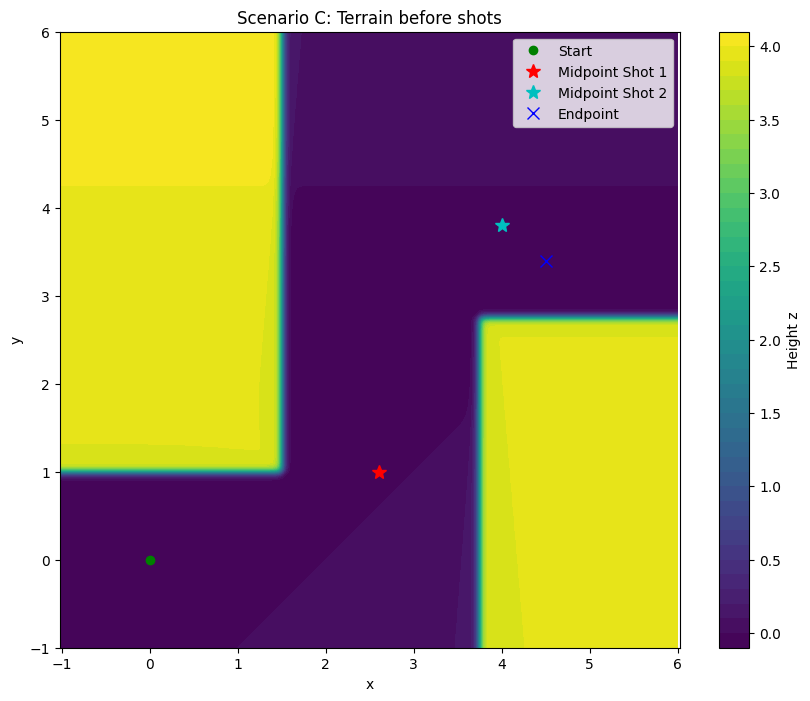

In [37]:
# Plot terrain for Scenario C before any shots
surface = ScenarioC()
x_range = np.linspace(-1, 6, 300)
y_range = np.linspace(-1, 6, 300)
X, Y = np.meshgrid(x_range, y_range)
Z = surface.height(X, Y)

plt.figure(figsize=(10, 8))
cs = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(cs, label='Height z')
plt.title('Scenario C: Terrain before shots')
plt.xlabel('x')
plt.ylabel('y')
# Mark start and common midpoints/targets
plt.plot(0, 0, 'go', label='Start')
plt.plot(2.6, 1.0, 'r*', markersize=10, label='Midpoint Shot 1')
plt.plot(4.0, 3.8, 'c*', markersize=10, label='Midpoint Shot 2')
plt.plot(4.5, 3.4, 'bx', markersize=8, label='Endpoint')
plt.legend()
plt.axis('equal')
plt.show()

Slope magnitude at midpoint: 0.1556
Friction coefficient: 0.075
Shot 1 Optimization: Optimization terminated successfully.
Optimal Velocity: [2.5163254  0.76335002]
Ball stopped at: [3.05714852 2.73714861]
Shot 1 Optimization: Optimization terminated successfully.
Optimal Velocity: [2.5163254  0.76335002]
Ball stopped at: [3.05714852 2.73714861]


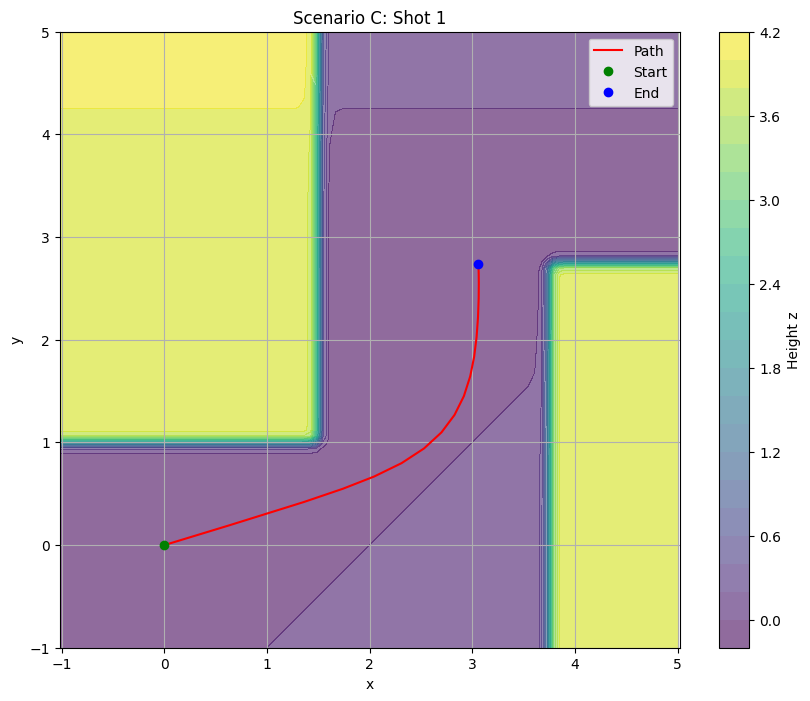

In [38]:
surface = ScenarioC()
physics = PhysicsEngine(surface)
solver = ShootingSolver(physics)
from scipy.integrate import solve_ivp

# Physics check: can the ball stop at the target midpoint physically?
grad = surface.gradient(2.6, 1.0)
slope_mag = np.linalg.norm(grad)
friction_limit = physics.mu

print(f"Slope magnitude at midpoint: {slope_mag:.4f}")
print(f"Friction coefficient: {friction_limit}")

if slope_mag > friction_limit:
    print("WARNING: Ball cannot stop statically at this midpoint!")

# Event function for stopping
def ball_stopped(t, y):
    vx, vy = y[2], y[3]
    speed = np.sqrt(vx**2 + vy**2)
    return speed - 1e-3
ball_stopped.terminal = True
ball_stopped.direction = -1

from scipy.optimize import minimize

# Target midpoint from coursework
target_midpoint = np.array([2.6, 1.0])

def shot1_objective(params):
    vx0, vy0 = params
    initial_state = [0, 0, vx0, vy0]
    sol = solve_ivp(physics.equations_of_motion, [0, 10], initial_state, events=ball_stopped, rtol=1e-6, atol=1e-6, dense_output=True)
    # If solver failed, give a big penalty
    if sol.status == -1:
        return 100.0
    t_eval = np.linspace(0, sol.t[-1], 100)
    path = sol.sol(t_eval)
    positions = path[:2, :].T
    dists = np.linalg.norm(positions - target_midpoint, axis=1)
    min_dist = np.min(dists)
    stop_penalty = 0.0 if sol.status == 1 else 10.0
    return min_dist + stop_penalty

# Run optimization for Shot 1 (optimize only initial velocities)
guess1 = [2.0, 1.0]
res = minimize(shot1_objective, guess1, method='Nelder-Mead', tol=1e-3)
print("Shot 1 Optimization:", res.message)
print("Optimal Velocity:", res.x)

# Get stop position if optimization was successful
if res.success:
    vx_opt, vy_opt = res.x
    sol_final = solve_ivp(physics.equations_of_motion, [0, 10], [0,0,vx_opt,vy_opt], events=ball_stopped, rtol=1e-6, atol=1e-6, dense_output=True)
    stop_pos = sol_final.y[:2, -1]
    print(f"Ball stopped at: {stop_pos}")
    plot_trajectory(surface, sol_final, title="Scenario C: Shot 1")
else:
    stop_pos = target_midpoint
    print("Optimization failed; fallback start for Shot 2 set to midpoint")

start_pos_2 = stop_pos

In [39]:
# After Shot 1 optimization, show stopping position and prepare Shot 2 start
if res.success:
    # sol_final was created in the optimization cell and contains the trajectory
    print("Shot 1 succeeded. Final stopping point used for Shot 2 shown below.")
    print(f"Stop position: {stop_pos}")
else:
    print("Shot 1 optimization failed; using midpoint as fallback.")
    stop_pos = target_midpoint

start_pos_2 = stop_pos
print(f"Starting position for Shot 2: {start_pos_2}")

Shot 1 succeeded. Final stopping point used for Shot 2 shown below.
Stop position: [3.05714852 2.73714861]
Starting position for Shot 2: [3.05714852 2.73714861]


In [40]:
# Shot 2
midpoint_2 = np.array([4.0, 3.8])
endpoint_2 = np.array([4.5, 3.4])

def objective_shot2(params):
    vx0, vy0, T1, T2 = params
    if T1 <= 0.1 or T2 <= T1 + 0.1:
        return [100, 100, 100, 100]

    initial_state = [start_pos_2[0], start_pos_2[1], vx0, vy0]

    from scipy.integrate import solve_ivp
    sol = solve_ivp(physics.equations_of_motion, [0, T2], initial_state, rtol=1e-8, atol=1e-8, dense_output=True, events=ball_stopped)

    if not sol.success and sol.status != 1:
        return [100, 100, 100, 100]

    # Use the dense output to get state at T1 if possible; otherwise fall back to last state
    try:
        state_T1 = sol.sol(T1)
    except Exception:
        state_T1 = sol.y[:, -1]

    if sol.status == 1:
        # Stopped early; final state is last available
        state_T2 = sol.y[:, -1]
    else:
        state_T2 = sol.sol(T2)

    return [
        state_T1[0] - midpoint_2[0],
        state_T1[1] - midpoint_2[1],
        state_T2[0] - endpoint_2[0],
        state_T2[1] - endpoint_2[1]
    ]

guess2 = [1.0, 1.0, 1.0, 2.0]
sol2 = solver.solve(objective_shot2, guess2)

print("Shot 2 Solution:", sol2.x)
print("Success:", sol2.success)

Shot 2 Solution: [1.22398032 1.48238677 0.95278591 2.98615767]
Success: True


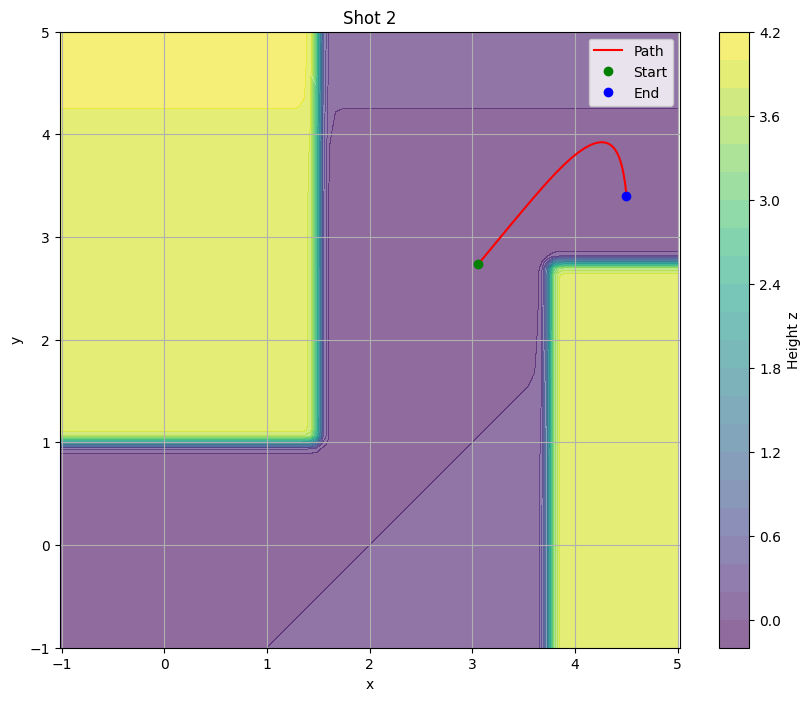

In [41]:
if sol2.success:
    vx0, vy0, T1, T2 = sol2.x
    initial_state = [start_pos_2[0], start_pos_2[1], vx0, vy0]
    sol_path2 = solver.integrate(initial_state, [0, T2])
    plot_trajectory(surface, sol_path2, title="Shot 2")